# COMP 562 Final Project
### Multinomial Image Classification using SVMs, Neural Networks, and Random Forests
Dataset of 365 classes, each with 50 samples. Each sample is an image. We use 10 of these classes for this assignment because of time and computational constraints. Thus, we have a dataset of 500 samples.

We converted each sample into a histogram of oriented gradients (HOGs)

## Andrew: Random Forests 

In [2]:
# Load in the data using Nate's code

In [48]:
from pathlib import Path
import pickle

import numpy as np

database_path = Path().cwd() / 'hog_matrix_2'
with open(database_path / 'labels.pkl', "rb") as fp:
    label_list = pickle.load(fp)

hog_matrix = np.load(database_path / 'hog_matrix.npy')

print(hog_matrix.shape)
print(len(label_list))

(48188, 3780)
48188


In [49]:
# Imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
import matplotlib.pyplot as plt

In [50]:
def test_and_train_accuracy(classifier: RandomForestClassifier, features_training: np.ndarray, features_testing: np.ndarray, labels_training: np.ndarray, labels_testing: np.ndarray) -> tuple:
    """Given a RandomForestClassifier, a training set, and a testing set, returns the accuracy of the classifer on both the test and training set. Useful to determine
     if your model is overfitting."""
    classifier_test_preds: np.ndarray = classifier.predict(features_testing)
    classifier_test_acc: float = accuracy_score(labels_testing, classifier_test_preds)
    print("Test Set Accuracy:", classifier_test_acc)

    classifier_train_preds: np.ndarray = classifier.predict(features_training)
    classifier_train_acc: float = accuracy_score(labels_training, classifier_train_preds)
    print("Train Set Accuracy:", classifier_train_acc)

    return classifier_test_acc, classifier_train_acc

In [51]:
# Explanation of the data
# 10 classes, each class has about 5,000 images (samples)
# Thus, there are 48,188 images in total. Nate converted each one to a HOG as a vector of length 8,100. 
# Thus, we have 48,1888 HOGs, each of length 8100, and each with a label denoting which class it is from  
# Each element of the vector is a feature, so each sample has 8100 features and 1 class label that we predict

In [52]:
# Randomly split the data into 70% training and 30% Testing
features_train, features_test, class_train, class_test = train_test_split(hog_matrix, label_list, test_size=0.3)

# Verify that training and testing sets were correctly split
print(features_train.shape[0] + features_test.shape[0] == hog_matrix.shape[0])
features_train.shape, features_test.shape, len(class_train), len(class_test)

True


((33731, 3780), (14457, 3780), 33731, 14457)

In [7]:
# Do a single decision tree at first just for comparison, but don't spend any time trying to optimize the single tree. Instead just jump straight into random forests 
# dt: DecisionTreeClassifier = DecisionTreeClassifier()
# dt.fit(features_train, class_train)

In [80]:
# Evaluate Accuracy of Single Decision Tree
dt_preds_test: np.ndarray = dt.predict(features_test)
dt_acc_test: float = sum([dt_preds_test[i] == class_test[i] for i in range(len(dt_preds_test))]) / len(dt_preds_test)
print(f"Accuracy on Training Set: {dt_acc_test}")

dt_preds_train: np.ndarray = dt.predict(features_train)
dt_acc_train: float = sum([dt_preds_train[i] == class_train[i] for i in range(len(dt_preds_train))]) / len(dt_preds_train)
print(f"Accuracy on Training Set: {dt_acc_train}")
#9m01s. Clearly over fit!

Accuracy on Training Set: 0.26582278481012656
Accuracy on Training Set: 0.9996442441670866


## Pilot RandomForestClassifier
Why Random Forest?
* Should reduce overfitting by using mutliple, minimally correlated decision trees to make predictions
* Should improve classification accuracy 

To save computational effort upfront, we started by training a classifier with 30 estimators (decision trees). 

We try 4 max_depths: 5, 7, 9, 11, to demonstrate that as the maximum depth of estimators increases, the model begins to overfit and model accuracy improves only minimally. 
 - max_depth must be at least 4 because we attempt to classify 10 classes, and a decision tree can make at most as many classifications as it has leaf nodes. 
 - A decision tree of depth 3 can classify into at most 8 classes, and a decision tree of depth 4 can classify into at most 16 classes. 

How each tree is formed
* Each tree is made from a random subset of features and a bootstrapped random sample of samples. Max # of features sampled is set as the sqrt of total # of features.
* max # of samples is set to features_train.shape[0] = 33731.   
* the rest of the parameters are set to scikitlearn's defaults

In [53]:
depth_list: list = [5, 7, 9, 11]
n_estimators: int = 30
test_accs: list = []
train_accs: list = []

for depth in depth_list:
    rf_30_depth = RandomForestClassifier(n_estimators=n_estimators, max_depth=depth)
    rf_30_depth.fit(features_train, class_train)
    results: tuple = test_and_train_accuracy(rf_30_depth, features_train, features_test, class_train, class_test)
    test_accs.append(results[0])
    train_accs.append((results[1]))
    print("Done with depth =", depth)

Test Set Accuracy: 0.3583731064536211
Train Set Accuracy: 0.384927811212238
Done with depth = 5
Test Set Accuracy: 0.3960019367780314
Train Set Accuracy: 0.48975719664403666
Done with depth = 7
Test Set Accuracy: 0.41488552258421524
Train Set Accuracy: 0.6582668761673238
Done with depth = 9
Test Set Accuracy: 0.41979663830670266
Train Set Accuracy: 0.8517980492721828
Done with depth = 11


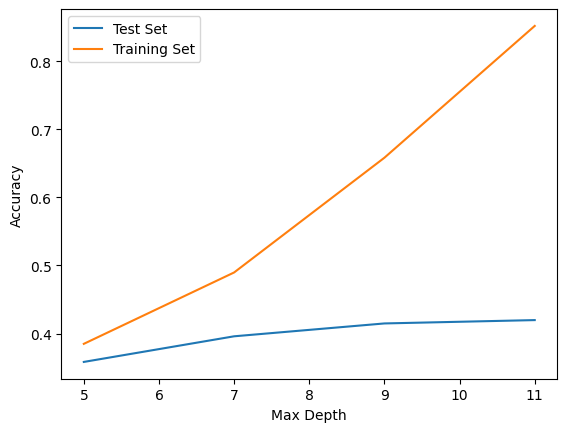

In [54]:
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.plot(depth_list, test_accs, label = "Test Set")
plt.plot(depth_list, train_accs, label = "Training Set");
plt.legend()

In [55]:
# Now, we have roughly determined that using a max_depth of 9 is a decent tradeoff between computational effort and model performance. 
# In this cell, we will run a model with a max_depth of 9 on an increasing number of estimators to determine how increasing the number
estimators_list: list = list(range(50, 201, 50))
max_depth: int = 9
test_accs_estimator_experiment: list = []
train_accs_estimator_experiment: list = []

for estimators in estimators_list:
    rf_estimators_9 = RandomForestClassifier(n_estimators=estimators, max_depth=max_depth)
    rf_estimators_9.fit(features_train, class_train)
    results: tuple = test_and_train_accuracy(rf_estimators_9, features_train, features_test, class_train, class_test)
    test_accs_estimator_experiment.append(results[0])
    train_accs_estimator_experiment.append((results[1]))
    print("Done with num_estimators =", estimators)

Test Set Accuracy: 0.43203984229093173
Train Set Accuracy: 0.6864605259257063
Done with num_estimators = 50
Test Set Accuracy: 0.44538977657881995
Train Set Accuracy: 0.7168776496397972
Done with num_estimators = 100
Test Set Accuracy: 0.4503008923013073
Train Set Accuracy: 0.7211467196347573
Done with num_estimators = 150
Test Set Accuracy: 0.4522376703327108
Train Set Accuracy: 0.727579970946607
Done with num_estimators = 200


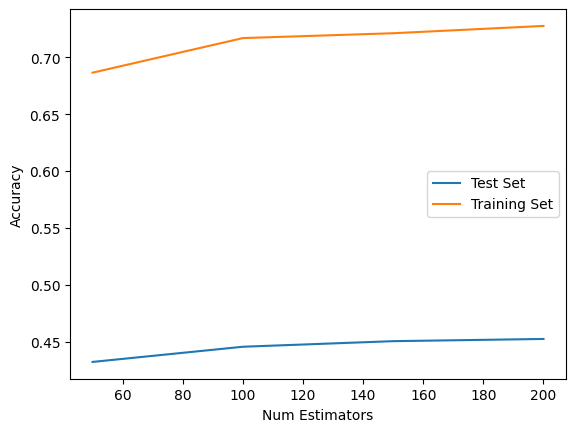

In [63]:
plt.xlabel("Num Estimators")
plt.ylabel("Accuracy")
plt.plot(estimators_list, test_accs_estimator_experiment, label = "Test Set")
plt.plot(estimators_list, train_accs_estimator_experiment, label = "Training Set");
plt.legend()

In [73]:
# It appears as though a classifier with 100 estimators and max depth of 9 has similar performance to classifiers with more estimators and deeper trees. 
# So, if we're gonna want to improve classification accuracy, we should try modifying some other params. First, lets fit our baseline classifier
rf_100_9: RandomForestClassifier = RandomForestClassifier(n_estimators=100, max_depth=9)
rf_100_9.fit(features_train, class_train) 
# Time: 5m39s for hog_matrix. 

RandomForestClassifier(max_depth=9)

In [74]:
test_and_train_accuracy(rf_100_9, features_train, features_test, class_train, class_test)

Test Set Accuracy: 0.44314173064951234
Train Set Accuracy: 0.686018158236057


(0.44314173064951234, 0.686018158236057)

In [75]:
rf_100_9_preds: np.ndarray = rf_100_9.predict(features_test)
accuracy: float = accuracy_score(class_test, rf_100_9_preds)
precision: float = precision_score(class_test, rf_100_9_preds, average=None)
recall: float = recall_score(class_test, rf_100_9_preds, average=None)

# IDK HOW TO INTERPRET
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.44314173064951234
Precision: [0.59036145 0.58722359 0.3042362  0.41766382 0.30822597 0.7038835
 0.39059675 0.43531828 0.40677966 0.43219512]
Recall: [0.82094241 0.45136922 0.23867069 0.73007968 0.31995885 0.18637532
 0.20970874 0.72272727 0.28458498 0.46387435]


In [36]:
# Randomized Hyperparameter Tuning using 5-fold cross validation. max_layers limited to 10 so as to minimize overfitting but still have high prediction accuracy
param_dist: dict = {
    'n_estimators': randint(100, 120),
    'max_depth': randint(8,10),
    'min_samples_leaf': randint(1, int(features_train.shape[0] * 0.001)),
    "min_samples_split": randint(2, int(features_train.shape[0] * 0.05)),
}

# Create a random forest classifier
rf_hyperparam_tuning: RandomForestClassifier = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf_hyperparam_tuning, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5,
                                 refit=True)

# Fit the random search object to the data
rand_search.fit(features_train, class_train) # took 91m20s

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001810450CB90>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001810452DAD0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001802FFA4ED0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000018033E42A10>})

In [40]:
best_params = rand_search.best_params_
best_params

{'max_depth': 8,
 'min_samples_leaf': 7,
 'min_samples_split': 94,
 'n_estimators': 100}

In [60]:
rf_best: RandomForestClassifier = RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_leaf=7, min_samples_split=94)
rf_best.fit(features_train, class_train)
test_and_train_accuracy(rf_best, features_train, features_test, class_train, class_test)

Test Set Accuracy: 0.4292038458878052
Train Set Accuracy: 0.5550087456642258


(0.4292038458878052, 0.5550087456642258)

In [61]:
rf_100_9_94_100: RandomForestClassifier = RandomForestClassifier(max_depth = 15, min_samples_leaf=7, min_samples_split=94)
# Changing the min_samples_leaf and min_samples_split parameters enabled us to reduce overfitting while increasing accuracy! 
# Let's try again but with more estimators
rf_100_9_94_100.fit(features_train, class_train)
test_and_train_accuracy(rf_100_9_94_100, features_train, features_test, class_train, class_test)

Test Set Accuracy: 0.4593622466625164
Train Set Accuracy: 0.7501111736977855


(0.4593622466625164, 0.7501111736977855)

In [62]:
rf_250_9_94_100: RandomForestClassifier = RandomForestClassifier(n_estimators = 250, max_depth = 15, min_samples_leaf=7, min_samples_split=94)
rf_250_9_94_100.fit(features_train, class_train)
test_and_train_accuracy(rf_250_9_94_100, features_train, features_test, class_train, class_test)

Test Set Accuracy: 0.4729888635263194
Train Set Accuracy: 0.7621772256974296


(0.4729888635263194, 0.7621772256974296)

In [64]:
# Split into 80/20 and rerun rf_250_9_94_100
features_train, features_test, class_train, class_test = train_test_split(hog_matrix, label_list, test_size=0.2)

# Verify that training and testing sets were correctly split
print(features_train.shape[0] + features_test.shape[0] == hog_matrix.shape[0])
features_train.shape, features_test.shape, len(class_train), len(class_test)

True


((38550, 3780), (9638, 3780), 38550, 9638)

In [65]:
rf_250_9_94_100: RandomForestClassifier = RandomForestClassifier(n_estimators = 250, max_depth = 15, min_samples_leaf=7, min_samples_split=94)
rf_250_9_94_100.fit(features_train, class_train)
test_and_train_accuracy(rf_250_9_94_100, features_train, features_test, class_train, class_test)

Test Set Accuracy: 0.4782112471467109
Train Set Accuracy: 0.7584954604409857


(0.4782112471467109, 0.7584954604409857)

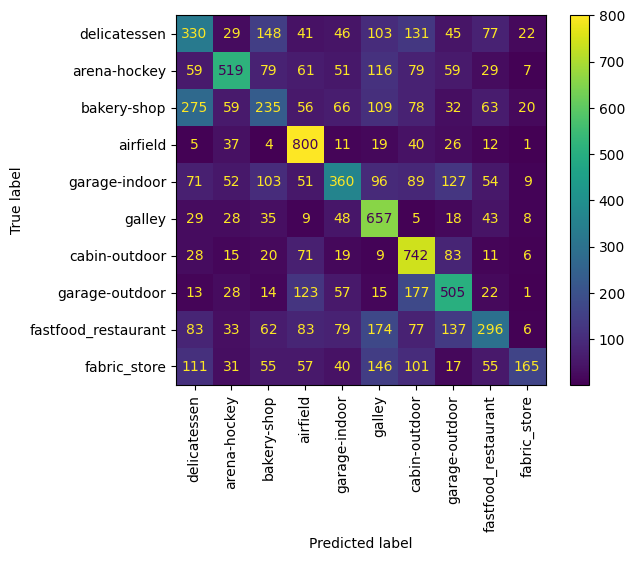

In [67]:
rf_250_9_94_100: np.ndarray = rf_250_9_94_100.predict(features_test)
labels: list = list(set(label_list))
cm_250_9_94_100: np.ndarray = confusion_matrix(class_test, rf_250_9_94_100, labels=labels)
ConfusionMatrixDisplay(confusion_matrix=cm_250_9_94_100, display_labels=labels).plot(xticks_rotation = "vertical");

# Some of the most misclassified: deli and bakery, garage outdoor and airfield, garage indoor and airfield, galley and fastfood restaurant, garage indoor and garage outdoor

In [ ]:
# Discuss error reduction methods
# Reducing correlation between trees, increasing the strength of each tree, tinkering with depth, bias-variance tradeoff, etc. 
# Hyperparameters?